# Explainable Wind Power Forecast with Lale & AIX360

<br>
<br>
<br>

Wind power is one of the most mature and cost-effective renewable technology we have, and it is likely to play a critical role in the transition to a greener and more sustainable energy infrastructure. The major downside of wind power is that it is highly intermittent. An accurate medium-term (up to 48h) wind power forecast can help energy operators to plan ahead and minimize the financial and environmental cost of firing up back-up fossil fuel plant, and help individual farm owners to maximize profit from energy trading.

Wind power forecast, however, is a highly complicated matter, especially for medium- and long-term forecast, as it involves many-step-ahead forecasts. In this project, the forecast is framed as a regression problem to find the relationship between the weather data and the power generation. Weather forecast is generally considered to be accurate up to 72h, so it's well suited for medium-term wind power forecast for business purposes.

The objective of this project to build a semi-automated data science pipeline and an explainable workflow (including preprocessing and feature selection) to select and validate various solutions. The robust workflow allows the continuous tuning and training of the models whenever new public data is received. 

In [1]:
# Install the following packages:
# !pip install lale
# !pip install aix360
# !pip install arrow

In [2]:
import pandas as pd
import numpy as np
import urllib.request, json
import arrow
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
pd.options.mode.chained_assignment = None

## Build Data Pipeline to Get Public Data

In this section, we define some helper functions and build a data pipeline to get weather and power data for Hornsdale Wind Farm Stage 2 (HDWF2) in South Australia. Power data is collected from an API provided by the Australian Renewable Energy Mapping Infrastructure Project (AREMI). The hourly weather data is collected from DarkSky API (R.I.P.) at matching time. All data is collected in its local timezone and converted to UTC.

The following code can be easily modified to get the data of any major wind farm in Australia. To ensure no missing point the datetime range, a reference range is defined with `get_ref_dt_range` and combined with the final dataframe. Missing values are also automatically filled with `fill_val`, unless there's a large portion of missing data, in which case the data should be handled manually. Note the API key for DarkSky is not included in this notebook for security reason, and you need to supply your own if you wish to replicate the result.

In [5]:
def fill_val(df,offset):
    '''
    Fill missing value with the mean of the -24h and +24h data
    offset is the rows for the +24h/-24h, for 1h interval is 24, for 5min interval is 288
    '''
    for item in df.drop('time',axis=1).columns:
        for i in df[df.isna().any(1)].index:
            # Take into consideration if missing values don't have -24h and +24h data 
            try:
                v_plus = df[item][i+offset]
            except:
                v_plus = np.nan
            try:
                v_minus = df[item][i-offset]
            except:
                v_minus = np.nan
            
            if not pd.isnull(v_plus) and not pd.isnull(v_minus):
                v = 0.5 * (v_plus + v_minus)
            elif pd.isnull(v_plus):
                v = v_minus
            elif pd.isnull(v_minus):
                v = v_plus
            else:
                v = np.nan
            
            df.loc[i,item] = v

In [6]:
def get_ref_dt_range(df,utc_start_dt,utc_end_dt,freq):
    '''
    Get a reference data range df given utc_start_dt, utc_end_dt, freq and merge it to original df
    This ensures df have no missing datatime range
    Missing values will show up as NaN, which can be filled later
    utc_start_dt,utc_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    freq is a string that speficy frequency(e.g., 5Min,1H)
    output if the df with no missing point in timeseries
    '''
    ref_dt_range = pd.date_range(utc_start_dt,utc_end_dt,freq=freq)
    ref_dt_range = pd.DataFrame(ref_dt_range,columns=['time'])
    ref_dt_range['time'] = ref_dt_range['time'].apply(str)
    df = pd.merge(df,ref_dt_range,left_on='time',right_on='time',how='outer',sort=True)
    
    return df

In [7]:
def get_power(local_start_dt,local_end_dt,offset):
    '''
    Get the power data given farm and time period
    local_start_dt,local_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    offset if a string corresponds to how far away from current time
    return a dataframe with power output in 1h interval, with no gap in time series or missing value 
    '''
    tz = 'Australia/Adelaide'
    dt_format = 'YYYY-MM-DD HH:mm:ss'
    utc_start_dt = arrow.get(local_start_dt).replace(tzinfo=tz).to('UTC').format(dt_format)
    utc_end_dt = arrow.get(local_end_dt).replace(tzinfo=tz).to('UTC').format(dt_format)

    # The api only returns data from the offset time to current time. Offset value should be estimated properly.
    # Usually a larger window is choosen, which is sliced to desired dt window later.
    power_api = f'https://services.aremi.data61.io/aemo/v6/duidcsv/HDWF2?offset={offset}'
    power = pd.read_csv(power_api)

    # Conver the time format from ISO to dt_format 
    power['time'] = power['Time (UTC)'].apply(lambda t: arrow.get(t).format(dt_format)) 
    power.drop(['Time (UTC)'],axis = 1, inplace=True)

    # Get the row of the start date and end date, slice the df to desired dt range
    start_index = 0
    if power['time'][0] > utc_start_dt:
        pass # in case utc_start_time is after the data start time
    else:
        while not (utc_start_dt in str(power['time'][start_index])):
            start_index += 1            

    end_index = len(power) -1 # search from bottom to top for better performance
    while not (utc_end_dt in str(power['time'][end_index])):
        end_index -= 1
    power = power[start_index:end_index]    

    # Join the reference dt range. If there's missing time points the row will show as NaN.
    power = get_ref_dt_range(power,utc_start_dt,utc_end_dt,'5Min')
    power.drop_duplicates(subset='time', keep='first', inplace=True)
    power.reset_index(drop=True,inplace=True)

    # Fill missing value, if any
    fill_val(power,288)

    # Set negative values to 0, if any
    for i in power[power['MW'] < 0].index:
        power.loc[i,'MW'] = 0

    # Converts power output in 5min interval to 1h interval, the power is the mean of the power recorded within the hour.
    power1h = pd.DataFrame()
    for i in range(len(power)//12):
        power1h.loc[i, 'time'] = power[i*12:(i+1)*12]['time'][i*12]
        power1h.loc[i, 'power'] = power[i*12:(i+1)*12]['MW'].mean()
        
    return power1h

In [8]:
def get_weather(local_start_dt,local_end_dt):
    '''
    Get the raw weather data from Darksky, given the farm and time period
    local_start_dt,local_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    returns dataframe is hourly weather data 
    '''
    dt_format = 'YYYY-MM-DD HH:mm:ss'
    tz = 'Australia/Adelaide'
    dakrskykey = '' # provided by DarkSky
    location = '-33.042878,138.556285' # coordinate of Hornsdale Wind Farm
    flags = '?exclude=currently,daily,flags&units=si'

    # Set a dt range, call the api for each day's data in the dt range
    local_dt_range = pd.date_range(local_start_dt, local_end_dt, freq = '1D')

    weather = pd.DataFrame()
    for dt in local_dt_range[:-1]:
        # Construct the api url for each day
        time = dt.strftime("%Y-%m-%d")+'T00:00:00'
        dsapi = f'https://api.darksky.net/forecast/{dakrskykey}/{location},{time}{flags}'

        # Load the json from api and turns to df, attach each day's df to the master weather df
        with urllib.request.urlopen(dsapi) as url:
            data = json.loads(url.read().decode())     
        try:
            df = pd.DataFrame(data['hourly']['data'])
        except:
            df = pd.DataFrame()
        weather = pd.concat([weather,df],axis = 0,sort=True)
    # Convert UNIX time to time in dt_format
    weather['time'] = weather['time'].apply(lambda t: arrow.get(int(t)).format(dt_format))       

    weather = weather[['time', 'cloudCover', 'dewPoint', 'humidity', 'ozone', 'precipIntensity', 'pressure',  
     'temperature',  'uvIndex', 'visibility', 'windBearing', 'windGust', 'windSpeed']]

    # make sure there's no missing point in time series
    weather = get_ref_dt_range(weather,weather.iloc[0,0],weather.iloc[-1,0],'1H')
    weather.drop_duplicates(subset='time', keep='first', inplace=True)
    weather.reset_index(drop=True,inplace=True)

    return weather

In [9]:
def combine_df(weather,power):    
    '''
    Combine weather and power1h data, if there's missing points in time for weather if will be filled;
    returns a cleaned dataframe with hourly weather and power output data 
    '''
    df = pd.merge(weather,power,left_on='time',right_on='time',how='outer',sort=True) 
    # Fill missing values
    fill_val(df,24)

    return df

In [11]:
# We will get data through Jul 2018 to April 2020, this can take a while
local_start_dt = '2018-07-01 00:00:00'
local_end_dt = '2020-04-01 00:00:00'

power = get_power(local_start_dt,local_end_dt,'36M')

weather = get_weather(local_start_dt,local_end_dt)

df = combine_df(weather,power)

df.to_csv('HDWF2.csv',index=False)

## Preprocessing Data
### EDA

In [3]:
df = pd.read_csv('./HDWF2.csv')
df.head(3)

,time,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,power
0,2018-06-30 13:30:00,0.02,0.09,0.85,355.0,0.0,1031.6,2.41,0.0,16.093,108.0,1.81,1.39,0.0
1,2018-06-30 14:30:00,0.01,-0.12,0.85,355.8,0.0,1031.6,2.20,0.0,16.093,107.0,1.89,1.45,0.0
2,2018-06-30 15:30:00,0.01,-0.43,0.84,356.5,0.0,1031.4,1.98,0.0,16.093,105.0,2.00,1.48,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15384 entries, 0 to 15383
Data columns (total 14 columns):
time               15384 non-null object
cloudCover         15384 non-null float64
dewPoint           15384 non-null float64
humidity           15384 non-null float64
ozone              15384 non-null float64
precipIntensity    15384 non-null float64
pressure           15384 non-null float64
temperature        15384 non-null float64
uvIndex            15384 non-null float64
visibility         15384 non-null float64
windBearing        15384 non-null float64
windGust           15384 non-null float64
windSpeed          15384 non-null float64
power              15384 non-null float64
dtypes: float64(13), object(1)
memory usage: 1.6+ MB


In [5]:
# Make sure there's no missing values
df[df.isna().any(1)]

,time,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,power


C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning

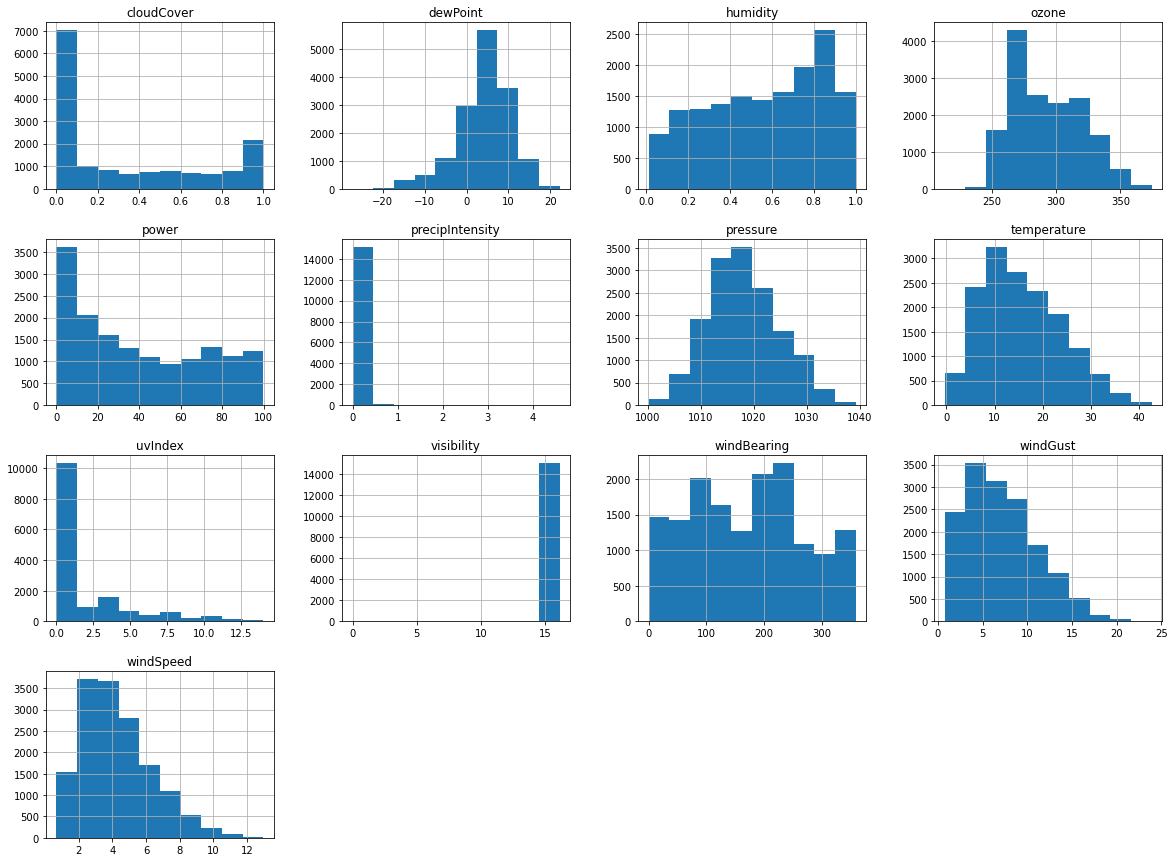

In [6]:
import matplotlib.pyplot as plt
# plot an overview of the distribution of each column
df.hist(figsize=(20,15));

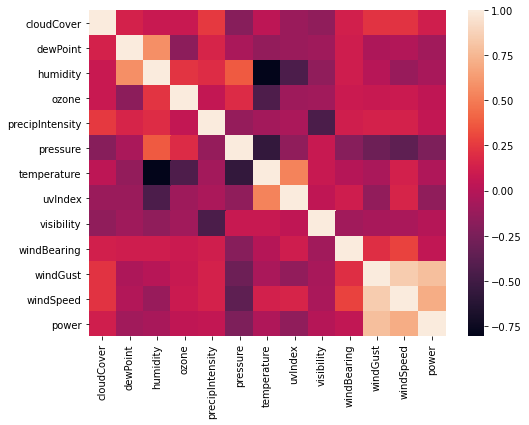

In [7]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr());

The data appears to be rather clean with no missing values or obvious errors. 

Heatmap shows only `windSpeed` and `windGust` is well-correlated with `power`. In addition, the `precipIntensity` and `visibility` columns have very low variance. Feature selection may be needed to improve model performance, which will be part of the model training pipeline.

### Feature Engineering
The ideal wind power generation is described by the following formula: 

\begin{equation} P = \frac{1}{2} \rho S c_p W_s^3 \end{equation}

where $P$ is the power output, $\rho$ is the density of the air, $S$ is the rotor surface, $c_{p}$ is the power coefficient, and $W_{s}$ is the speed of the wind.

Through the above heatmap and formula, our intuition is that the `windSpeed` and `WindGust` will be the most important predictors.

For feature engineering, the cubic values of `windSpeed` and `WindGust` are then included as features, as well as air density. Density is calculated through temperature, pressure, and dew point/humidity in `cal_density`.

In [8]:
def cal_density(T,P,Td):
    '''
    Calcuate the air density rho (kg/m^3) given temperature T 
    (Celsius C), Pressure P(hPa) and dew point (Celsius C)
    Ref: https://www.gribble.org/cycling/air_density.html
    '''
    
    eso = 6.1078
    c0 = 0.99999683
    c1 = -0.90826951E-2
    c2 = 0.78736169E-4
    c3 = -0.61117958E-6
    c4 = 0.43884187E-8
    c5 = -0.29883885E-10
    c6 = 0.21874425E-12
    c7 = -0.17892321E-14
    c8 = 0.11112018E-16
    c9 = -0.30994571E-19
    p = c0 + Td *(c1 + Td *(c2 + Td *(c3 + Td *(c4 + \
        Td *(c5 + Td *(c6 + Td *(c7 + Td *(c8 + Td *(c9)))))))))
    Pv = eso / p**8
    
    Pd  = P - Pv
    Tk = T + 273.15
    
    Rv = 461.4964
    Rd = 287.0531
    
    rho = ((Pd / (Rd * Tk)) + (Pv / (Rv * Tk)))*100
    
    return rho

df['density'] = cal_density(df.temperature,df.pressure,df.dewPoint)

In [9]:
# Generate cubic values for speed and gust
df['windSpeed3'] = df['windSpeed']**3
df['windGust3'] = df['windGust']**3
# windBearing is a rotational data, which can be troublesome, so it's converted to sine and cosine components 
df['windSin'] = np.sin(df.windBearing * np.pi / 180.)
df['windCos'] = np.cos(df.windBearing * np.pi / 180.)

df.drop(['time','windBearing'],axis=1,inplace=True)

In [10]:
df.head()

,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windGust,windSpeed,power,density,windSpeed3,windGust3,windSin,windCos
0,0.02,0.09,0.85,355.0,0.0,1031.6,2.41,0.0,16.093,1.81,1.39,0.000000,1.301228,2.685619,5.929741,0.951057,-0.309017
1,0.01,-0.12,0.85,355.8,0.0,1031.6,2.20,0.0,16.093,1.89,1.45,0.000000,1.302265,3.048625,6.751269,0.956305,-0.292372
2,0.01,-0.43,0.84,356.5,0.0,1031.4,1.98,0.0,16.093,2.00,1.48,0.000000,1.303118,3.241792,8.000000,0.965926,-0.258819
3,0.02,-0.76,0.83,357.3,0.0,1031.2,1.78,0.0,16.093,2.15,1.50,0.058333,1.303880,3.375000,9.938375,0.992546,-0.121869
4,0.01,-1.12,0.84,355.8,0.0,1031.4,1.33,0.0,16.093,2.39,1.58,0.300000,1.306344,3.944312,13.651919,0.998630,0.052336


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15384 entries, 0 to 15383
Data columns (total 17 columns):
cloudCover         15384 non-null float64
dewPoint           15384 non-null float64
humidity           15384 non-null float64
ozone              15384 non-null float64
precipIntensity    15384 non-null float64
pressure           15384 non-null float64
temperature        15384 non-null float64
uvIndex            15384 non-null float64
visibility         15384 non-null float64
windGust           15384 non-null float64
windSpeed          15384 non-null float64
power              15384 non-null float64
density            15384 non-null float64
windSpeed3         15384 non-null float64
windGust3          15384 non-null float64
windSin            15384 non-null float64
windCos            15384 non-null float64
dtypes: float64(17)
memory usage: 2.0 MB


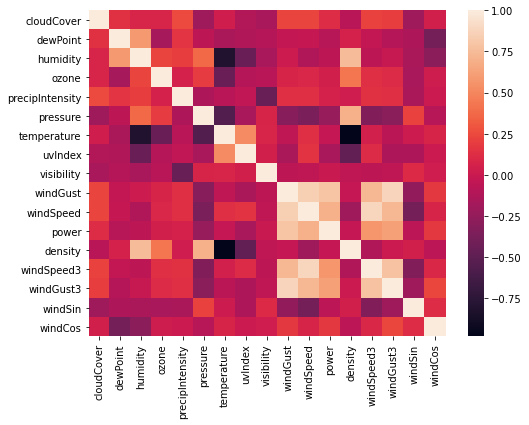

In [12]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr());

## Semi-automated Model Training Pipeline with LALE

In [13]:
X = df.drop(['power'],axis=1)
y = df['power']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9,random_state=42)

In [19]:
import lale
from lale.lib.lale import NoOp, Hyperopt

In [20]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import StandardScaler as Standard
from xgboost import XGBRegressor as XGB

lale.wrap_imported_operators()

In [209]:
import lale.schemas as schemas
# Custom operator to limit n_estimators and max_depth, saving time and reducing overfitting
Custom_RFR = RFR.customize_schema(
    n_estimators=schemas.Int(min=2, max=250),
    max_depth=schemas.Int(min=2, max=12),
    )
Custom_XGB = XGB.customize_schema(
    n_estimators=schemas.Int(min=2, max=250),
    max_depth=schemas.Int(min=2, max=12),
    )

In `planned_pipe`, data is first standardized, then the pipeline will choose to use `PCA` for feature selection or `NoOp`. Then the pipeline will choose among support vector machine, random forest or XGBoost models. The topology of planned pipeline is shown as follows:

In [16]:
planned_pipe = Standard >> (PCA|NoOp) >> (SVR|Custom_RFR|Custom_XGB)
# planned_pipe.visualize()

![alt text](images/planned_pipe.png "Topology of planned pipeline")

In [211]:
trainable_pipe = Hyperopt(estimator = planned_pipe, cv = 3, max_evals = 50, scoring='neg_mean_squared_error')

In [212]:
trained = trainable_pipe.fit(X_train, y_train)

100%|██████████| 50/50 [38:28<00:00, 33.26s/trial, best loss: 172.90396117730788]  


In [216]:
# prints the pipelines with the top 5 lowest loss
trained.summary().loss.sort_values().head()

name
p34    172.903961
p22    176.024841
p44    182.555948
p37    182.785347
p35    184.664394
Name: loss, dtype: float64

In [15]:
# trained.get_pipeline().visualize()

![alt text](images/trained.png "Topology of trained pipeline")

Interestingly, the best estimator didn't do feature selection with `PCA`. Perhaps this is because all the weak predictors show poor multicollinearity per the heat map. This will remain to be explained with packages such as `Lime`.

In [220]:
trained.get_pipeline().pretty_print(show_imports= False, ipython_display= True)
'''
In case it doesn't show, the result is:
standard = Standard(with_mean=False, with_std=False)
xgb = XGB(colsample_bylevel=0.7303217366356366, colsample_bytree=0.6725489818299374, learning_rate=0.14324868120461248, max_depth=8, min_child_weight=20, n_estimators=185, reg_alpha=0.07500751793952769, reg_lambda=0.0464726417219788, subsample=0.8939712982118808)
pipeline = standard >> NoOp() >> xgb
'''

```python
standard = Standard(with_mean=False, with_std=False)
xgb = XGB(colsample_bylevel=0.7303217366356366, colsample_bytree=0.6725489818299374, learning_rate=0.14324868120461248, max_depth=8, min_child_weight=20, n_estimators=185, reg_alpha=0.07500751793952769, reg_lambda=0.0464726417219788, subsample=0.8939712982118808)
pipeline = standard >> NoOp() >> xgb
```

In [221]:
from sklearn.metrics import mean_squared_error as mse

In [222]:
print(f'The RMSE of trained pipeline on train set is: {np.sqrt(mse(trained.predict(X_train),y_train))}')
print(f'The RMSE of trained pipeline on test set is: {np.sqrt(mse(trained.predict(X_test),y_test))}')

The RMSE of trained pipeline on train set is: 7.051502546695817
The RMSE of trained pipeline on test set is: 12.352040363907967


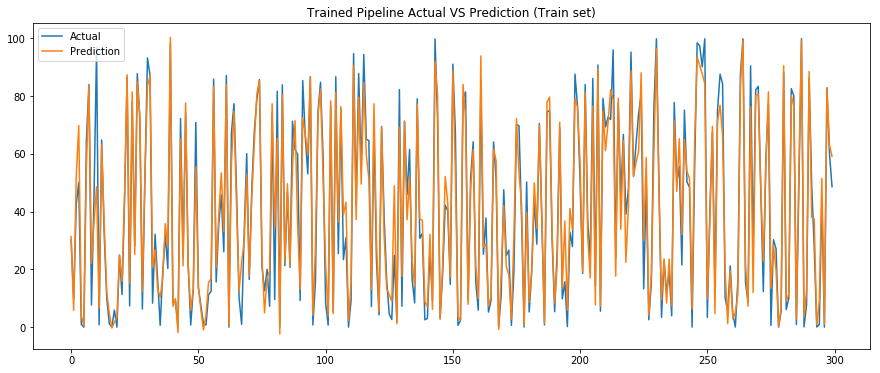

In [235]:
plt.figure(figsize=(15,6))
plt.plot(y_train.values[:300], label='Actual')
plt.plot(trained.predict(X_train)[:300], label='Prediction')
plt.title('Trained Pipeline Actual VS Prediction (Train set)')
plt.legend();

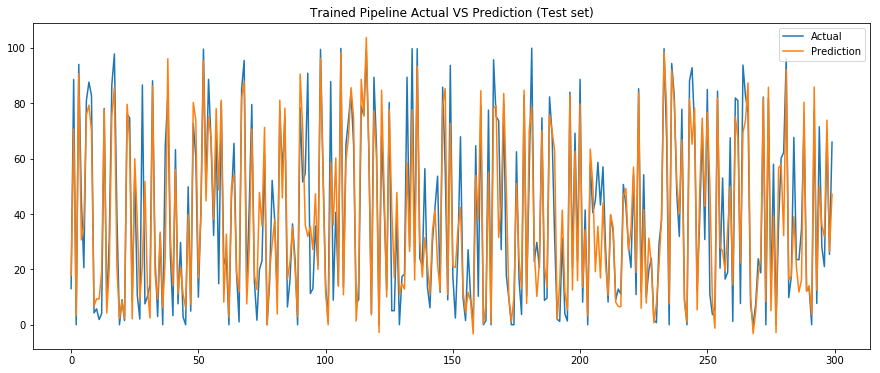

In [239]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values[:300], label='Actual')
plt.plot(trained.predict(X_test)[:300], label='Prediction')
plt.title('Trained Pipeline Actual VS Prediction (Test set)')
plt.legend();

## Explainability with Lime

In [240]:
from aix360.algorithms.lime import LimeTabularExplainer

In [241]:
ip_lime = LimeTabularExplainer(X_test.values, feature_names = X_test.columns, mode='regression')

The below chart shows an example (index `i`=42 of the test set) of how the model makes predictions. The most influential predictors are `windGust`,`windGust3`,`windSpeed` and `windSpeed3`, which validates our intuition. Additionally, the chart validates that the inclusion of the cubic wind during feature engineering is successful, while `density` is less impactful. All predictors except for `visibility` played a role in making the predictions.

In [242]:
i=42

lime_explainer = ip_lime.explain_instance(X_test.values[42], trained.predict, num_features=16)
# lime_explainer.show_in_notebook(show_table = True, show_all = False)

![alt text](images/lime.png "Result of Lime")

## Explainability with Shap
To use Shap's `TreeExplainer` for better performance, we need to replicate the results of the model training pipeline. Fortunately, Lale's `pretty_print()` method (see above) has offered exactly the code we can use.

In [17]:
# Better reload the modules, as the previous imported ones have been wrapped as Lale objects
%load_ext autoreload
%autoreload 2
from sklearn.preprocessing import StandardScaler as Standard 
from xgboost import XGBRegressor as XGB

Interestingly, the arguments of `Standard` indicate the scaler doesn't actually do anything. This should be fine for XGBoost without any PCA, but for consistency's sake, we're replicating this step anyway.

In [31]:
ss = Standard(with_mean=False, with_std=False)
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [19]:
# Convert the scaled numpy array back to dataframe
Xs_train = pd.DataFrame(Xs_train,columns=X_train.columns)
Xs_test = pd.DataFrame(Xs_test,columns=X_test.columns)

In [20]:
xgb = XGB(colsample_bylevel=0.7303217366356366, colsample_bytree=0.6725489818299374, 
          learning_rate=0.14324868120461248, max_depth=8, min_child_weight=20, 
          n_estimators=185, reg_alpha=0.07500751793952769, reg_lambda=0.0464726417219788, 
          subsample=0.8939712982118808)

In [21]:
xgb.fit(Xs_train,y_train.values);

In [22]:
import shap
# shap.initjs()

In [23]:
shap_explainer = shap.TreeExplainer(xgb)
shap_values = shap_explainer.shap_values(Xs_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Below is the Shap's explaintion of how model predicts on the same data point (`i` = 42) as before. The result is somewhat consistent with Lime's interpretation.  

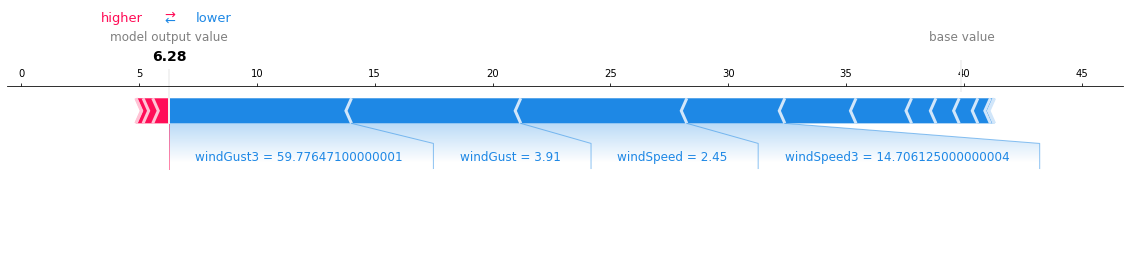

In [24]:
i = 42
shap.force_plot(shap_explainer.expected_value, shap_values[i,:], Xs_test.iloc[i,:],matplotlib=True)

Below is the explanations for the entire test set, sorted by `windGust3`.

In [25]:
#shap.force_plot(shap_explainer.expected_value, shap_values, Xs_test)

![alt text](images/shap_all.png "Shap explanations on test set")

Below is Shap's summary of all features impact. It is comparable to XGBoost's internal `.feature_importances_` attribute.

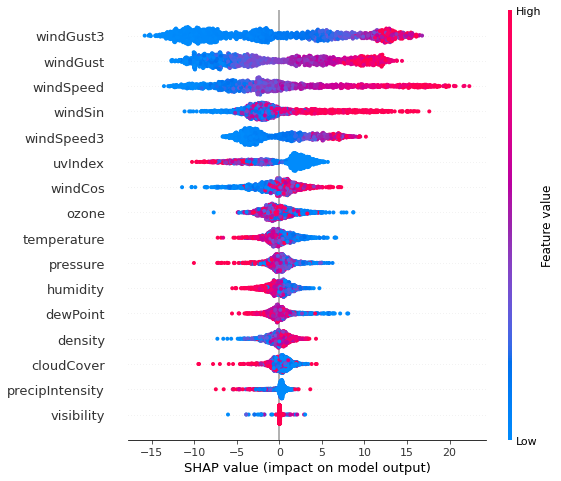

In [26]:
shap.summary_plot(shap_values, Xs_test)

In [27]:
# XGBoost's internal feature importance 
xgbcoef = pd.DataFrame({'feature':X_train.columns, 
                        'importance': xgb.feature_importances_*100})
xgbcoef[xgbcoef.importance>0].sort_values(by='importance',ascending=False).head(20).T

,13,12,10,9,7,14,15,6,8,0,1,2,3,11,4,5
feature,windGust3,windSpeed3,windSpeed,windGust,uvIndex,windSin,windCos,temperature,visibility,cloudCover,dewPoint,humidity,ozone,density,precipIntensity,pressure
importance,40.2317,14.2015,11.2559,8.768,5.10685,3.72034,3.21708,1.77598,1.67439,1.59552,1.49954,1.48696,1.4448,1.42541,1.34534,1.25065


Finally, we take a look at how change in some of the strongest predictors affect the model's prediction 

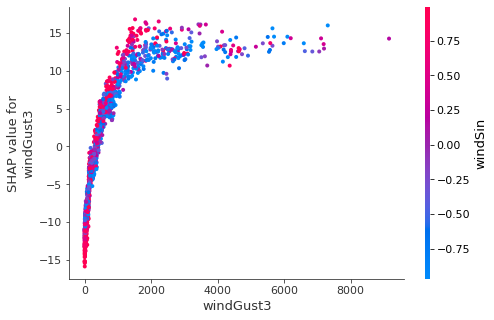

In [28]:
shap.dependence_plot('windGust3', shap_values, Xs_test)

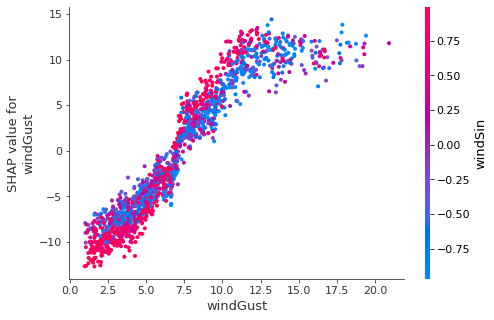

In [29]:
shap.dependence_plot('windGust', shap_values, Xs_test)

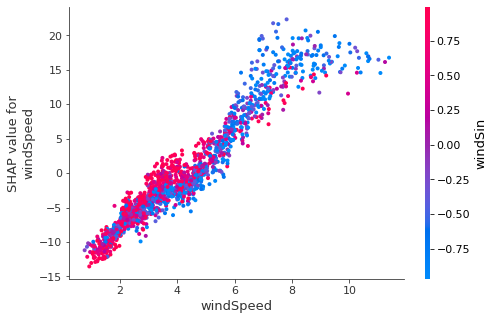

In [30]:
shap.dependence_plot('windSpeed', shap_values, Xs_test)

## Summary

This project showed a semi-automated data science pipeline and explainable workflow for wind power forecasts using Lale & Lime. This workflow enables data scientists to train, tweak and validate the pipeline with better explainability. 

In production, the semi-automated nature of the workflow allows data scientists to take real-time weather and power data through the pipeline defined in the first section to tune and re-train models with ease. 

Finally, because we use public data, anyone interested can develop their own models to forecast wind power with this robust workflow. 

![alt text](images/overview.png "An Overview of the workflow")